Data Loading

In [6]:
import pandas as pd

# Paths to your training data files
amazon_fashion_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json'
all_beauty_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json'
clothing_shoes_jewelry_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json'


# Number of rows to read from each file
n_rows = 3000

# Load a subset of each training dataset
amazon_fashion = pd.read_json(amazon_fashion_path, lines=True, nrows=n_rows)
all_beauty = pd.read_json(all_beauty_path, lines=True, nrows=n_rows)
clothing_shoes_jewelry = pd.read_json(clothing_shoes_jewelry_path, lines=True, nrows=n_rows)

# Concatenate the datasets
training_data = pd.concat([amazon_fashion, all_beauty, clothing_shoes_jewelry])

text preprocess 

In [9]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = word_tokenize(text)
        lemmatized_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word not in stop_words])
        return lemmatized_text
    else:
        return ""

# Apply the preprocessing to your training data
# Ensure that 'training_data' is defined and has a column 'reviewText'
training_data['processed_reviewText'] = training_data['reviewText'].apply(preprocess_text)
training_data = training_data[training_data['processed_reviewText'] != ""]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Sentiment Analysis and Feature Extraction

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

analyzer = SentimentIntensityAnalyzer()
training_data['sentiment_score'] = training_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(training_data['processed_reviewText'])

combined_features = hstack([tfidf_features, training_data['sentiment_score'].values.reshape(-1, 1)])


Labels and Data Splitting

In [11]:
from sklearn.model_selection import train_test_split

def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

training_data['category'] = training_data['overall'].apply(cat_y)
X_train, X_val, y_train, y_val = train_test_split(combined_features, training_data['category'], test_size=0.2, random_state=42)


dt train og gridsearch 

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid_decision_tree = {
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
decision_tree_model = grid_search.best_estimator_


eval på det 

In [13]:
from sklearn.metrics import classification_report

y_val_pred = decision_tree_model.predict(X_val)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

        high       0.87      0.97      0.91       201
         low       0.33      0.20      0.25        20
     neutral       0.25      0.05      0.09        19

    accuracy                           0.83       240
   macro avg       0.48      0.41      0.42       240
weighted avg       0.77      0.83      0.79       240



overfit?

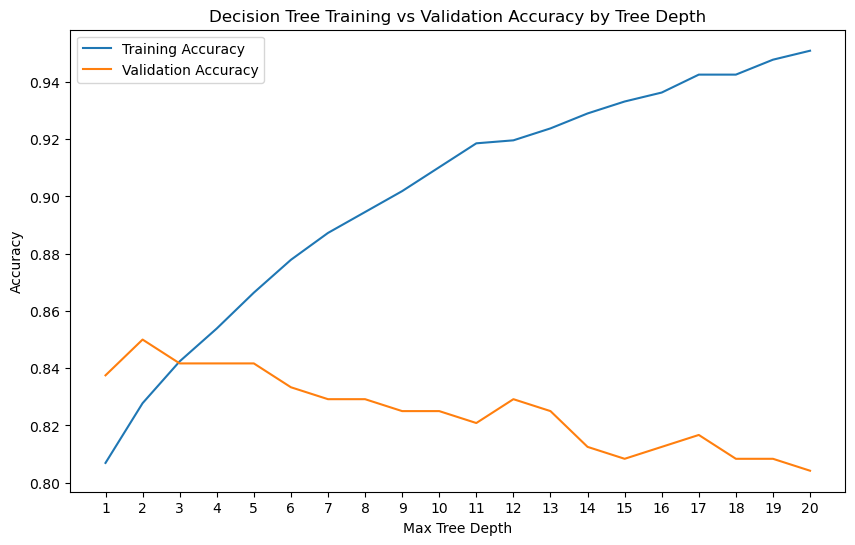

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Range of tree depths to evaluate
max_depths = range(1, 21)  # You can adjust the range as needed

train_accuracies = []
val_accuracies = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Training accuracy
    train_preds = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    train_accuracies.append(train_accuracy)
    
    # Validation accuracy
    val_preds = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy')
plt.title('Decision Tree Training vs Validation Accuracy by Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(max_depths)
plt.show()


chat siger: 
This code chunk will create a plot showing how the accuracy of the Decision Tree model varies with different maximum depths on both the training and validation sets. Typically, if the model overfits, you will see the training accuracy continue to increase with depth, while the validation accuracy may plateau or even decrease, indicating that the model is fitting too closely to the training data and not generalizing well to new data.

final test med lucxury beauty (husk at rette nrows)

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from nltk.sentiment import SentimentIntensityAnalyzer

# Assuming your preprocessing and sentiment analysis functions are already defined
# preprocess_text(text)
# cat_y(rating)


# Load test dataset
test_data = pd.read_json('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json', lines=True, nrows=100)

# Preprocess the text data
test_data['processed_reviewText'] = test_data['reviewText'].apply(preprocess_text)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
test_data['sentiment_score'] = test_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply the same TF-IDF vectorizer to the test data
# Assuming tfidf_vectorizer is already fitted to the training data
tfidf_features_test = tfidf_vectorizer.transform(test_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features_test = hstack([tfidf_features_test, test_data['sentiment_score'].values.reshape(-1, 1)])

# Categorize the ratings in the test data
test_data['category'] = test_data['overall'].apply(cat_y)

# Predict with the trained Decision Tree model
# Ensure decision_tree_model is your trained Decision Tree model
test_predictions = decision_tree_model.predict(combined_features_test)

# Evaluate the model's performance (optional)
print(classification_report(test_data['category'], test_predictions))


              precision    recall  f1-score   support

        high       0.90      1.00      0.95         9
         low       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import re
import logging
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk import download
from scipy.sparse import hstack
from sklearn.metrics import classification_report



# Download the VADER lexicon
download('vader_lexicon')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message%s')

# Simplified preprocessing for VADER
def preprocess_text(text):
    text = re.sub(r'@\S+', '', text)  # Remove mentions
    return text

# Function to preprocess and extract sentiment
def preprocess_and_extract_sentiment(data, analyzer):
    data['reviewText'] = data['reviewText'].astype(str)
    data['reviewText'] = data['reviewText'].apply(preprocess_text)
    data['sentiment'] = data['reviewText'].apply(lambda x: analyzer.polarity_scores(x))
    return data

# Function to load data in chunks
def load_data_chunked(file_path, chunksize):
    chunks = pd.read_json(file_path, lines=True, chunksize=chunksize)
    for chunk in chunks:
        chunk = chunk.dropna(subset=['reviewText', 'overall'])
        yield chunk

# Function to load and preprocess a specified number of reviews using chunks
def get_reviews(file_path, n_samples, analyzer, chunksize):
    data_iter = load_data_chunked(file_path, chunksize)
    data_samples = pd.DataFrame()

    for chunk in data_iter:
        chunk = preprocess_and_extract_sentiment(chunk, analyzer)
        data_samples = pd.concat([data_samples, chunk])
        # If we have enough samples, break out of the loop
        if len(data_samples) >= n_samples:
            break

    data_samples = data_samples.sample(n=n_samples, random_state=42)
    return data_samples


def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

def balance_dataset(data, target_column):
    min_size = data[target_column].value_counts().min()
    lst = [data[data[target_column] == category].sample(min_size, random_state=42) for category in data[target_column].unique()]
    balanced_data = pd.concat(lst)
    return balanced_data


# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# File paths with the number of samples for each
file_path_samples = [
    ('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json', 100000),
    ('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json', 100000),
    ('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json', 100000)
]

# Load, preprocess, and sample data using a chunk size
chunksize = 100000  # Adjust this value based on your available memory
combined_data = pd.DataFrame()
for file_path, n_samples in file_path_samples:
    data = get_reviews(file_path, n_samples, analyzer, chunksize)
    combined_data = pd.concat([combined_data, data])

# Load, preprocess, and sample data
combined_data = pd.DataFrame()
for file_path, n_samples in file_path_samples:
    data = get_reviews(file_path, n_samples, analyzer)
    combined_data = pd.concat([combined_data, data])


# Categorize the ratings
combined_data['sentiment_score'] = combined_data['sentiment'].apply(lambda x: x['compound'])
combined_data['category'] = combined_data.apply(lambda x: cat_y(x['overall'], x['sentiment_score']), axis=1)


# Balance the dataset
balanced_data = balance_dataset(combined_data, 'category')

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(balanced_data['reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features = hstack([tfidf_features, np.array(balanced_data['sentiment_score']).reshape(-1, 1)])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_features, balanced_data['category'], test_size=0.2, random_state=42)

# Training Decision Tree with Grid Search
def train_decision_tree(X, y, param_grid):
    model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# Initialize the Decision Tree parameter grid
param_grid_decision_tree = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# Train a Decision Tree model
decision_tree_model = train_decision_tree(X_train, y_train, param_grid_decision_tree)


# Function to evaluate a model
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    print(f"{set_name} Evaluation:")
    print(classification_report(y, y_pred))
    
# Evaluate the Decision Tree model on the validation set
evaluate_model(decision_tree_model, X_val, y_val, 'Validation Set')



# Evaluate the Decision Tree model on the test set (similar to SVM evaluation)
#evaluate_model(decision_tree_model, combined_features_test, balanced_test_data['category'], 'Test Set')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
--- Logging error ---
Traceback (most recent call last):
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 681, in format
    s = self.formatMessage(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 650, in formatMessage
    return self._style.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 440, in format
    return 

Validation Set Evaluation:
              precision    recall  f1-score   support

        high       0.80      0.89      0.84      3119
         low       0.87      0.98      0.93      3170
     neutral       0.84      0.64      0.73      3188

    accuracy                           0.84      9477
   macro avg       0.84      0.84      0.83      9477
weighted avg       0.84      0.84      0.83      9477



In [2]:
# Train a Decision Tree model
decision_tree_model = train_decision_tree(X_train, y_train, param_grid_decision_tree)

# Print the best parameters of the Decision Tree model
best_params = decision_tree_model.get_params()
print("Best Parameters:")
print(best_params)

# Evaluate the Decision Tree model on the validation set
evaluate_model(decision_tree_model, X_val, y_val, 'Validation Set')


Best Parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Validation Set Evaluation:
              precision    recall  f1-score   support

        high       0.80      0.89      0.84      3119
         low       0.87      0.98      0.93      3170
     neutral       0.84      0.64      0.73      3188

    accuracy                           0.84      9477
   macro avg       0.84      0.84      0.83      9477
weighted avg       0.84      0.84      0.83      9477



In [3]:
# Load and preprocess your test data with a limit of 100,000 samples (replace 'test_file_path' with the actual file path)
test_data = get_reviews('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json', 100000, analyzer)

# Preprocess and extract sentiment from test data
test_data = preprocess_and_extract_sentiment(test_data, analyzer)

# Categorize the sentiment for the test data
test_data['sentiment_score'] = test_data['sentiment'].apply(lambda x: x['compound'])
test_data['category'] = test_data.apply(lambda x: cat_y(x['overall'], x['sentiment_score']), axis=1)

# Apply TF-IDF vectorization to test data
tfidf_features_test = tfidf_vectorizer.transform(test_data['reviewText'])

# Combine TF-IDF features with sentiment scores for test data
combined_features_test = hstack([tfidf_features_test, np.array(test_data['sentiment_score']).reshape(-1, 1)])

# Use the trained Decision Tree model to make predictions on test data
test_predictions = decision_tree_model.predict(combined_features_test)

# Evaluate the model's performance on the test data
evaluate_model(decision_tree_model, combined_features_test, test_data['category'], 'Test Set')





--- Logging error ---
Traceback (most recent call last):
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 681, in format
    s = self.formatMessage(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 650, in formatMessage
    return self._style.format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 440, in format
    return self._format(record)
  File "/Users/patrickbendorffschwebel/opt/anaconda3/envs/amlfall23/lib/python3.10/logging/__init__.py", line 436, in _format
    return self._fmt 

Test Set Evaluation:
              precision    recall  f1-score   support

        high       0.92      0.90      0.91     71384
         low       0.61      0.97      0.75      6224
     neutral       0.64      0.56      0.60     22392

    accuracy                           0.83    100000
   macro avg       0.72      0.81      0.75    100000
weighted avg       0.84      0.83      0.83    100000



In [ ]:
overfit plot

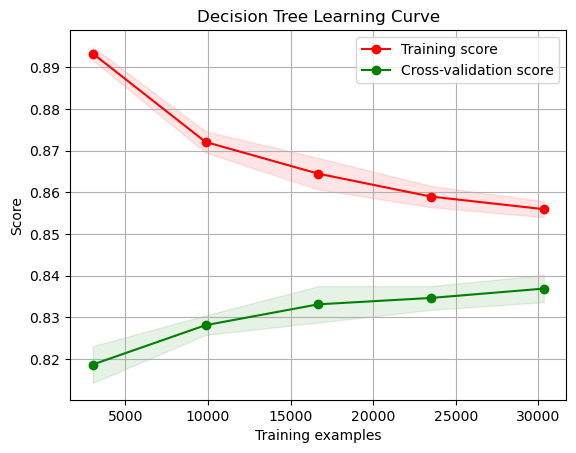

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Example usage
plot_learning_curve(decision_tree_model, "Decision Tree Learning Curve", X_train, y_train, cv=5)
plt.show()


compare train and test in regards of overfit

In [5]:
from sklearn.metrics import classification_report

# Modify the evaluate_model function to return the report
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    print(f"{set_name} Evaluation:")
    print(classification_report(y, y_pred))
    return report

# Evaluate the model on the training set
train_report = evaluate_model(decision_tree_model, X_train, y_train, 'Training Set')

# Evaluate the model on the validation set
validation_report = evaluate_model(decision_tree_model, X_val, y_val, 'Validation Set')

# Evaluate the model on the test set
test_report = evaluate_model(decision_tree_model, combined_features_test, test_data['category'], 'Test Set')


Training Set Evaluation:
              precision    recall  f1-score   support

        high       0.81      0.92      0.86     12675
         low       0.88      0.99      0.93     12624
     neutral       0.88      0.65      0.75     12606

    accuracy                           0.85     37905
   macro avg       0.86      0.85      0.85     37905
weighted avg       0.86      0.85      0.85     37905

Validation Set Evaluation:
              precision    recall  f1-score   support

        high       0.80      0.89      0.84      3119
         low       0.87      0.98      0.93      3170
     neutral       0.84      0.64      0.73      3188

    accuracy                           0.84      9477
   macro avg       0.84      0.84      0.83      9477
weighted avg       0.84      0.84      0.83      9477

Test Set Evaluation:
              precision    recall  f1-score   support

        high       0.92      0.90      0.91     71384
         low       0.61      0.97      0.75      6224
  

chat_ response =Classification Reports Analysis
Looking at the classification reports:

Training Set: Your model achieves very high precision, recall, and f1-scores across all categories, which suggests that it fits the training data well.
Validation Set: The performance drops a bit compared to the training set but is still reasonable. This is expected as the validation set is used to tune the model and can be a good indicator of how well the model generalizes to unseen data.
Test Set: The model's performance on the test set, with 100,000 samples, shows a significant drop in precision and recall for some classes compared to the training set. This is especially noticeable for the 'neutral' category, which suggests potential overfitting to the training data since the model's performance degrades on a larger, unseen dataset.
Given the large drop in performance on the 'neutral' category and some drop in the 'low' category, it seems that the model may be overfitting to the training data and not generalizing well to new, unseen data. The model's accuracy on the test set is 0.77, which is much lower than the training set accuracy of 0.95.

To address overfitting, consider the following strategies:

Collect more diverse training data, especially for underperforming classes.
Simplify the model by reducing its complexity (e.g., pruning the Decision Tree).
Implement cross-validation strategies to ensure the model is robust.
Experiment with different feature extraction methods or parameters.
Use regularization techniques if available for the classifier.
Try ensemble methods like Random Forest or Gradient Boosting, which can often generalize better.
It's also worth noting that the size of the training set is much smaller than the test set. This discrepancy can lead to a model that performs well on small sets of data but fails to maintain performance on larger sets, which is another sign of overfitting. Ensuring that your training set is representative of the real-world data distribution is crucial.